# HW 2 - Naive Bayes in Hadoop MR (Shishir Agarwal)
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2020`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "/media/notebooks/Assignments/HW2"

In [3]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [4]:
# data path
ENRON = "data/enronemail_1h.txt"

In [5]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ Hadoop MapReduce is based on "functional programming" paradigm in which one can define higher order function which take function name as one of the parameters. Thus, Map and Reduce functions are like higher order functions. This programming style avoids side-effects, mutable data and change in state. Which means output of the function solely depends on its input and the state of the program does not change when calling a function. Because there are no side-effects it is easy to parallelize the execution of a functions.

> __b)__ Hadoop Shuffle is the stage between Map phase and Reduce phase. This is phase during which Map phase and Reduce phase synchronize. Map functions run in parallel and once all Map functions complete, and before Reduce functions starts parallel execution, Hadoop shuffle takes the data (intermediate key-value pairs) from output of Map Stage and copies to Reduce stage and performs grouping and sorting by keys. It is costly because there is disk and network write. We can use combiners to optimize the traffic between map stage and reducer stage.   

> __c)__ The input and output of the combiners has to be the same because Hadoop does not gurantee execution of combiner. It executes combiner as an optimization stratgey to reduce amount of data that needs to get copied during the shuffle phase. Thus, combiners are written without changing the logic of the algorithms with the assumption that data coming into the reducer has the same format irrespective of whether combiners get run or not.

> __d)__ One can control the parallelization of Map and Reduce phase for optimal results. To control the Map phase one has to configure the block size within Hadoop. Hadoop uses the block size to decide how many chuncks to break the input data. To control the Reduce phase one can configure this through commandline. Even though the Map and Reduce phases can be parallelized the real bottleneck is during the Shuffle phase during which data is written to disk as well as sent over network which are both expensive operations in terms of performance.

> __e)__ With the advent of commodity compute and storage being available it became easy for companies to put together a server farm using commodity hardware as opposed to using expensive SMP machine. With commodity hardware it was easy to run programs in parallel on each of the server and storage farm to achieve most optimal performance for the program

# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ Counters are registers that keep information about a Hadoop job. Counters are useful for debugging, diagnosiing problems and collecting statitics about the Map Reduce Job. It is an easy way to flag a condition or statutics about the job without pouring over log files. Hadoop provide 3-types of built-in counters - Map Reduce Framework Counters, File System Counters and Job Counters. These counters provide us information on how many records are being processed by each mapper, combiner, reducer. It also provides insight into the overall job execution. You can create your own counters by writing additional Java code

> __b)__ Composite keys allow us to to combine the key with additional fields within the payload to form a composite key. Once the composite key is formed, one can use the Hadoop MapReduce Framework to sort or partition on a field within the composite key. This allows for easy what-if analysis when writing and debugging MapReduce jobs

> __c)__ Order Inverstion technique allows us to transmit certain statistics calculated by the mapper to all the reducers. This design pattern allows us to tackle problems like calculating relative frequencies of word without making 2 passes on the data. Especially when the data is large making 2 passes is expensive. Thus with order investion if mapper is doing the word count, it can at the same time count the total number of terms and transmit this information to all the reducers through custom partitioning. Once a reducer receives the sorted information the reducer can read the total count at the start of processing and then use it to calculate relative frequency without multiple pass at the data.


# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/blob/master/HelpfulResources/TotalSortGuide/total-sort-guide-hadoop-streaming.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ In partial sort, Keys are randomly assigned to each partition without any ordering. Keys are then sorted within each partition. In unordered total sort, keys are assigned to partition according to their numeric value. The result is keys end up in different bucket in a numeric order. Keys are sorted within each partition. Partitions are not assigned in sorted order. In total order sort, we do everything like unordered total sort but we also assign partitions in a sorted order. The total order sort allows us to find key-value pairs sorted in ascending or descending order after we merge the output from each partition. Partial sort and unordered total sort does not allow us to to find key-value pair in ascending or descending order. If we have one partition then we can get away with unordered total sort however if the data size is large we will typically create multiple partitions and if the partitions are not in order the merge of output file will not create key-value pairs in descending or ascending order unless we post-process the data again. Thus, for large data set Total Order Sort is of paramount importance.


> __b)__ We leverage the shuffle phase (partition and sort) of Map Reduce Execution Frameowrk to implement Total Order Sort. We change the default behavior on how the framework partitions the data and sorts the data within each partition before shipping the data over to reducers. We change this because we want to partition the data using a partition key from our custom partitioner instead of using the default partitioner. Also, we change the sort behavior because we want to typically sort based on a value field as opposed to the default alphanumeric sort based on the key. By default, Hadoop performs a partial sort on mapper output keys, i.e. within each partition keys are sorted.By default, keys are sorted as strings. When processing a mapper output record, first the partitioner decides which partition the record should be sent to. In shuffle and sort stage, keys within a partition are sorted. The partition index of a given key from mapper outputs is determined by the partitioner, the  default partitioner is HashPartitioner which relies on Java’s hashCode function to compute an integer hash for the key. The partition index is derived next by hash modulo number of reducers.


> __c)__ Hadoop streaming can be controlled through the command line options. Hadoop Streaming can be customized to use multiple fields for sorting, sort records by numeric order or keys and sort in reverse order.   

```
stream.num.map.output.key.fields
stream.map.output.field.separator
mapreduce.partition.keypartitioner.options
KeyFieldBasedComparator
keycomparator.options
partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
```

> __d)__ In order to preserve partition key ordering, we construct an "inverse hashCode function", which takes as input the desired partition index and total number of partitions, and returns the partition key. This key, when supplied to the Hadoop framework (KeyBasedPartitioner), will hash to the returned desired index. This is important to achieve Total Order Sort vs. Total Unordered Sort.   

> __e)__ This inverse hash function needs to be in the mapper code.  

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [6]:
!pwd

/media/notebooks/Assignments/HW2


In [7]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
#!head -n 5 /media/notebooks/Assignments/HW2/master/{ENRON} | cut -c-100
!head -n 5 /media/notebooks/Assignments/HW2/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [8]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/notebooks/Assignments/HW2/{ENRON}

100 /media/notebooks/Assignments/HW2/data/enronemail_1h.txt


In [9]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [10]:
# load the data into HDFS (RUN THIS CELL AS IS)
#!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/master/{ENRON} {HDFS_DIR}/enron.txt
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/{ENRON} {HDFS_DIR}/enron.txt

In [11]:
!hdfs dfs -ls {HDFS_DIR}

Found 1 items
-rw-r--r--   1 root supergroup     204559 2020-09-18 09:57 /user/root/HW2/enron.txt


# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ Assistance occurs 8 times in Spam and 2 times in Ham  

> __c)__ No it is not possible to sort by word count because our reducer function is expecting all the same words to be bunched-up together and if you use the Hadoop parameters to sort the by word count it will mess up the word order and result in an error during reduce phase  

> __d)__ I will take the results file and `cut` it into 2 files using the class field. Then I will `cat` each of the file and redirect the output to `head`.   

In [12]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [13]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [14]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	0	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	1	0
one	0	3
two	1	0
two	0	1


In [15]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

rm: `/user/root/HW2//eda-output': No such file or directory


In [16]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3429593115161946726.jar tmpDir=null
20/09/18 09:57:59 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:57:59 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:58:00 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 09:58:00 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 09:58:01 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0001
20/09/18 09:58:01 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0001
20/09/18 09:58:01 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0001/
20/09/18 09:58:01 INFO mapreduce.Job: Running job: job_1600422418834_0001
20/09/18 09:58:12 INFO mapreduce.Job: Job job_1600422418834_0001 running in uber mode : false
20/09/18 09:58:12 INFO mapreduce.Job:  map 0% reduce 0%
20/09

In [17]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [18]:
# part b - write your grep command here
!cat EnronEDA/results.txt | grep assistance

assistance	1	8
assistance	0	2


In [19]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output
!hdfs dfs -rm -r {HDFS_DIR}/results.txt

rm: `/user/root/HW2//eda-sort-output': No such file or directory
rm: `/user/root/HW2//results.txt': No such file or directory


In [20]:
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/EnronEDA/results.txt {HDFS_DIR}/results.txt

In [21]:
# part d - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2 -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/results.txt \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1419551023128598389.jar tmpDir=null
20/09/18 09:58:57 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:58:57 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:58:58 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 09:58:58 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 09:58:58 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0002
20/09/18 09:58:58 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0002
20/09/18 09:58:59 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0002/
20/09/18 09:58:59 INFO mapreduce.Job: Running job: job_1600422418834_0002
20/09/18 09:59:08 INFO mapreduce.Job: Job job_1600422418834_0002 running in uber mode : false
20/09/18 09:59:08 INFO mapreduce.Job:  map 0% reduce 0%
20/09

In [22]:
!hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-00000 | head

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.


In [23]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

Deleted /user/root/HW2/eda-sort-output


In [24]:
# part e - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k3,3nr" \
  -D mapreduce.partition.keypartitioner.options="-k2,2" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/results.txt \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6204540477524973691.jar tmpDir=null
20/09/18 09:59:42 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:59:42 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 09:59:43 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 09:59:43 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 09:59:43 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0003
20/09/18 09:59:44 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0003
20/09/18 09:59:44 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0003/
20/09/18 09:59:44 INFO mapreduce.Job: Running job: job_1600422418834_0003
20/09/18 09:59:52 INFO mapreduce.Job: Job job_1600422418834_0003 running in uber mode : false
20/09/18 09:59:52 INFO mapreduce.Job:  map 0% reduce 0%
20/09

In [25]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135	
cat: Unable to write to output stream.

===== part-00001=====

the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153	
cat: Unable to write to output stream.


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ `Map output records=14558` and `Reduce input records=14558` These are total number of terms or words in the Enron data


> __c)__ `Map output records=14558` and `Reduce input records=13096` This shows Hadoop Run Time ran the combiner and reduced the number of recoprds. Thus data coming into reducer is lower than when running the job without the combiner. Most probably it is combining words that are common across each email in the enron data.

> __d)__ If none of the email records had overlapping words across different emails then we will not need to run the combiner. Bonus - It depends on how many overlapping words do we have within each email. Let us assume we have the word `assistance` in each of 100 emails. Then we will have 100 records with `assistance` emitted whether we have 1 mapper or 100 mapper. Thus, increasing the number of mappers will not affect the efficiency of the combiner. Thus, how effective a combiner is dependent on the word overlap between emails as opposed to number of mappers.

In [26]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [27]:
# part b - write your Hadoop streaming job here
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6094000383848385789.jar tmpDir=null
20/09/18 10:00:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:00:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:00:42 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:00:42 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:00:42 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0004
20/09/18 10:00:43 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0004
20/09/18 10:00:43 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0004/
20/09/18 10:00:43 INFO mapreduce.Job: Running job: job_1600422418834_0004
20/09/18 10:00:52 INFO mapreduce.Job: Job job_1600422418834_0004 running in uber mode : false
20/09/18 10:00:52 INFO mapreduce.Job:  map 0% reduce 0%
20/09

In [29]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [30]:
# Checking Reduce Output Records Counter matches with results.txt
!wc -l EnronEDA/results.txt

10130 EnronEDA/results.txt


In [31]:
# part b - write your grep command here
!cat EnronEDA/results.txt | grep assistance

assistance	1	8
assistance	0	2


# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ Refer to mathematical notation below. We need Prior probability for each class $P(c)$. We also need the conditional probability which is the likelihood of seeing the terms together $P(d/c)$. We do not need the probability of evidence $P(d)$ because we are comparing the posterior probability $P(c/d)$ for each of the class and picking the class with the maximum value. To calculate prior probability we calculate the relative frequency of each class across the training set. To calculate likelihood we use the chain rule as well as assume each feature is conditionally independent. 

> __b)__ $P(c)$ means either $P(ham)$ or $P(spam)$. It is calculated by calculating the relative frequency of ham record or spam record in the corpus or training set. $\hat{P}(t_{k} | c)$ means probability of each term or word within all words under a specific class. We calculate this by finding the relative frequency of a word within subset of records that are either spam or ham. We can make 1 pass at the data to calculate the relative frequency and the total word counts. Once we have the word counts then we go over each of the word count record to calculate the relative frequency. The second pass is shorter because number of records are equal to the unique words in the corpus. This maps to 1 MapReducer job.

> __c)__ Refer below


> __d)__ Refer below

> __e)__ Without smoothing I will classify the document as $0$ (not about China). However in the book if we use Laplace smoothing then the document is classified as $1$ (about China). With smoothing we correct for zero probability calculated due to words not seen during training of the model.


In [32]:
!pwd

/media/notebooks/Assignments/HW2


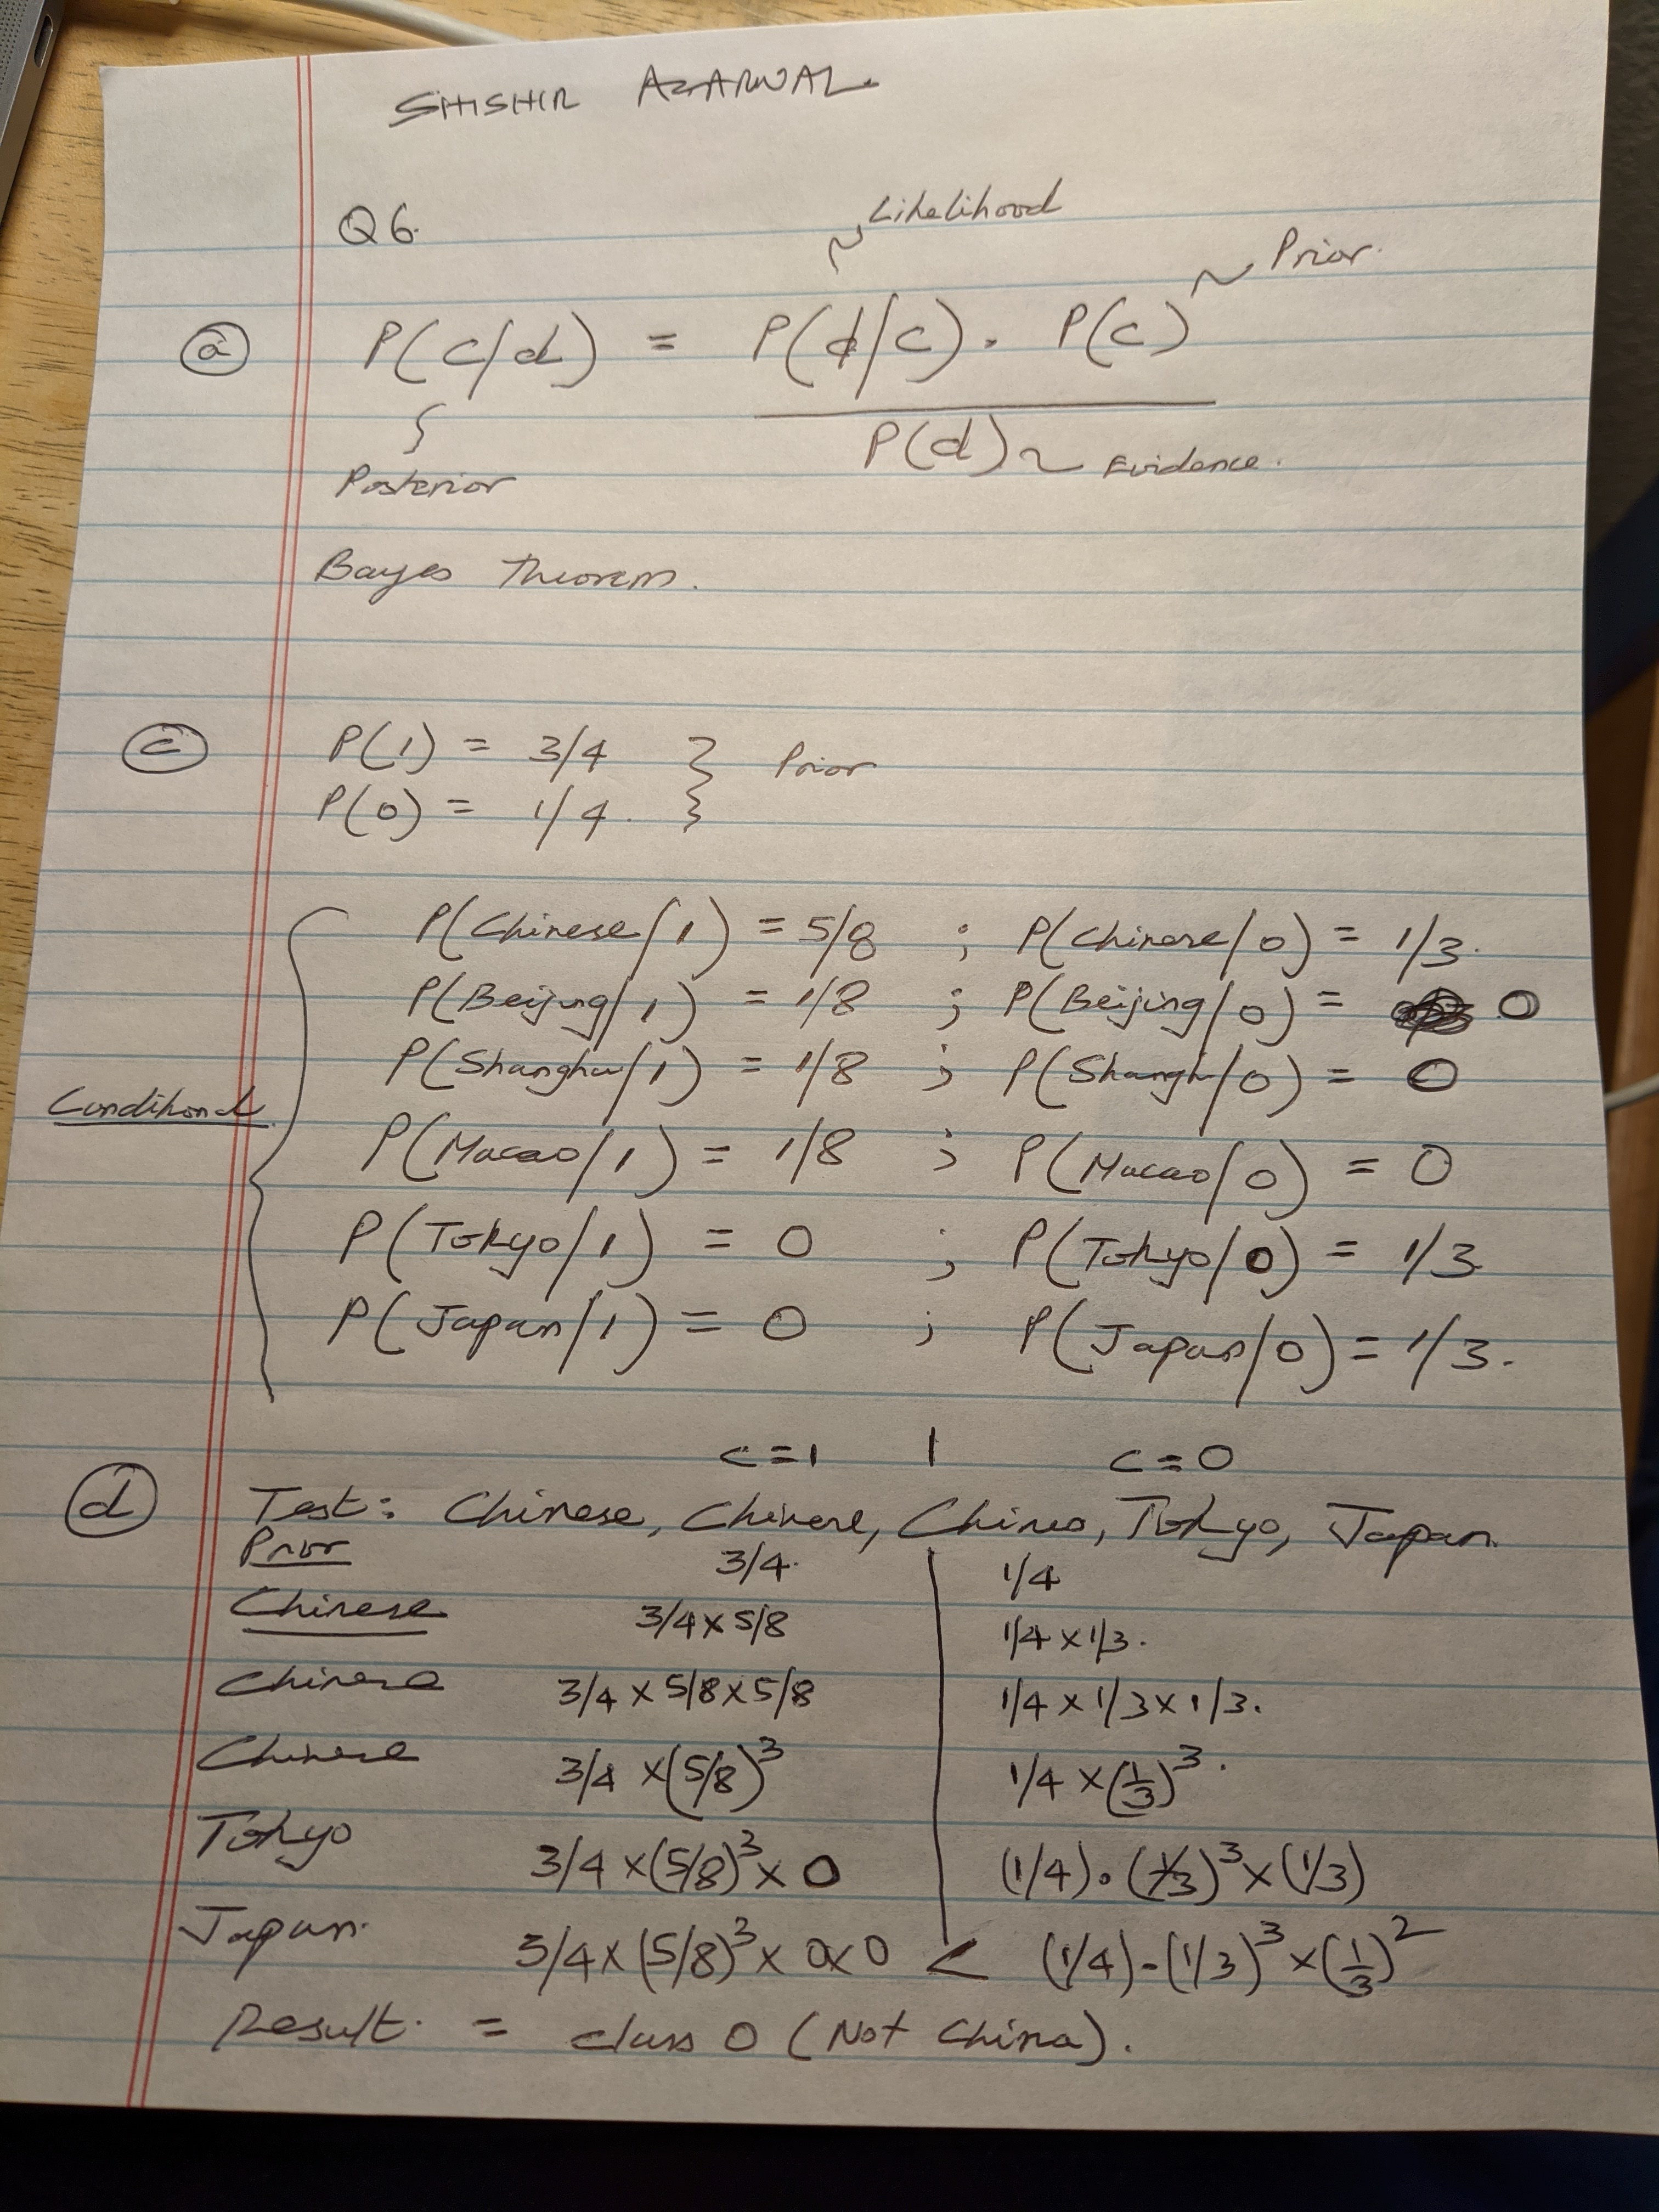

In [33]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
#Image(filename="path-to-hand-calulations-image.png")
Image(filename="HW2_Shishir_Agarwal.jpg")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ The key is the first field of the record and the value is the next 4 field of the record. The key consists of the word and the value consists of (a) count of the word in "China Related" document (b) count of words in "Non China Related" document (c) relative frequency (conditional probability)of the word in "China Related Document" (d) relative frequency (conditional probability) of the word in "Non China Related" document. The record with key "ClassPriors" is different because this record is generated by the MapReduce program as opposed to being part of the corpus. Also, each of the fields represent the marginal probability as opposed to conditional probability.

> __b)__ When we multiply probablities which are values less than 1 we quickly start having very small floating point numbers that are difficult to represent on computers and result into an underflow. We use log to avoid the underflow and work in a domain that is easier to represent. In the log domoin each probability multiplication is represented by log addition. If we have a unsmoothed model, it is easy to get zero as unconditional probability especially for words that were not part of the training set. In such scenario a $log(0)$ results into $inf$ or undefined values.

> __c)__ When a word does not appear in the training set and it only appears in the test set we can either remove the record from the training set or we assume the log of conditional probability is defaulted to zero. It is like ignoring the record since zero value gets added to both the log probabilities.

> __d)__ As long as we are only reading the model and not writing the model back it should be ok. In general loading the model state departs from the functional programming however if it is read-only then we avoid side-effects because what we read-in stays constant. From scalability perspective, it is hard to scale any traffic going over the network or being written to the disk. If the model file is cached into the memory then it should be ok since the file is in-memory.

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ In the mapper we can continue to read the model file and calculate the $logP(ham|doc)$ and $logP(spam|doc)$ for each word emit those out without performing any prediction. Then we move the comparison of the log values to make a prediction into  the reducers.


Run these cells to create the example corpus and model.

In [34]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting NaiveBayes/chineseTrain.txt


In [35]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting NaiveBayes/chineseTest.txt


In [36]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Overwriting NBmodel.txt


In [37]:
# load the data files into HDFS
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

Your work for `part e` starts here:

In [38]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [39]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [40]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

rm: `/user/root/HW2//chinese-output': No such file or directory


In [41]:
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob8572123280383188.jar tmpDir=null
20/09/18 10:02:17 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:02:18 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:02:19 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:02:19 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:02:19 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0005
20/09/18 10:02:19 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0005
20/09/18 10:02:19 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0005/
20/09/18 10:02:19 INFO mapreduce.Job: Running job: job_1600422418834_0005
20/09/18 10:02:28 INFO mapreduce.Job: Job job_1600422418834_0005 running in uber mode : false
20/09/18 10:02:28 INFO mapreduce.Job:  map 0% reduce 0%
20/09/18

In [42]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [43]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 5.


* __c) short response:__ We saw in Question 6 that adding Laplace +1 smoothing makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 



__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:`_You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Student Answers:
> __c)__We need the count of unique terms (vocab size) in the corpus

> __d)__In general because we perform EDA on our dataset we will know the vocab size and it will be easist to use option 1 and pass it as a parameter into the commandline. This is the option I chose. This is not ideal because one has to perform this activity outside the MapReduce framework and it can be error prone. If we choose the second option then we need to post-process the output file. We need another MapReduce job because it will require us to make another pass at the data to count unique number of words. The downside is making another pass at the data can be resource intensive. There is Third option which is to use the counter value from MapReduce Reducer Output to get the number of records and use it with the reducer. This in my opinion will be the best option

> __e)__I use the first option because it is simple to implement. During the EDA phase I can find number of unique words and use this information to run the smoothing. I use `wc-l` to find the number of records in the output results. I subtract one for `ClassPriors` and I use this as the count for unique words.


In [44]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py
!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.

INPUT:
    partitionKey \t word \t class0_partialCount \t class1_partialCount       
OUTPUT:
    word \t class0_wordcount \t class1_wordcount \t class0_relfreq \t class1_relfreq


In [45]:
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese


In [46]:
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py 

A	chinese	0	1
A	beijing	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	shanghai	0	1
A	chinese	0	1
A	macao	0	1
A	tokyo	1	0
A	japan	1	0
A	chinese	1	0
A	**total_terms	3	8
A	**total_docs	1	3


__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [47]:
# part b - write a unit test for your mapper here
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 -k2,2

A	**total_docs	1	3
A	**total_terms	3	8
A	beijing	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	1	0
A	japan	1	0
A	macao	0	1
A	shanghai	0	1
A	tokyo	1	0


In [48]:
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 -k2,2 | NaiveBayes/train_reducer.py

ClassPriors	1,3,0.25,0.75
beijing	0,1,0.000000000000000,0.125000000000000
chinese	1,5,0.333333333333333,0.625000000000000
japan	1,0,0.333333333333333,0.000000000000000
macao	0,1,0.000000000000000,0.125000000000000
shanghai	0,1,0.000000000000000,0.125000000000000
tokyo	1,0,0.333333333333333,0.000000000000000


In [49]:
# part b - write a unit test for your reducer here

In [50]:
# part b - write a systems test for your mapper + reducer together here

In [51]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

Deleted /user/root/HW2/chinese-output


In [52]:
# part b - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/train_mapper.py NaiveBayes/train_reducer.py\
  -mapper train_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH}\
  -numReduceTasks 1

20/09/18 10:03:26 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/train_mapper.py, NaiveBayes/train_reducer.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5025198030789278704.jar tmpDir=null
20/09/18 10:03:27 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:03:27 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:03:28 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:03:28 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:03:29 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0006
20/09/18 10:03:29 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0006
20/09/18 10:03:29 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0006/
20/09/18 10:03:29 INFO mapreduce.Job: Running job: job_16004

In [53]:
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-00000 | NaiveBayes/train_reducer.py

ClassPriors	1,3,0.25,0.75
beijing	0,1,0.000000000000000,0.125000000000000
chinese	1,5,0.333333333333333,0.625000000000000
japan	1,0,0.333333333333333,0.000000000000000
macao	0,1,0.000000000000000,0.125000000000000
shanghai	0,1,0.000000000000000,0.125000000000000
tokyo	1,0,0.333333333333333,0.000000000000000


In [54]:
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/train_mapper.py NaiveBayes/train_reducer.py\
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH}\
  -numReduceTasks 3

Deleted /user/root/HW2/chinese-output
20/09/18 10:04:11 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/train_mapper.py, NaiveBayes/train_reducer.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob393120018973194916.jar tmpDir=null
20/09/18 10:04:13 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:04:13 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:04:14 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:04:14 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:04:14 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0007
20/09/18 10:04:15 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0007
20/09/18 10:04:15 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0007/
20/09/18 10:04:15 INFO 

In [55]:
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* | column -t

japan        1,0,0.333333333333333,0.000000000000000
macao        0,1,0.000000000000000,0.125000000000000
shanghai     0,1,0.000000000000000,0.125000000000000
tokyo        1,0,0.333333333333333,0.000000000000000
ClassPriors  1,3,0.25,0.75
beijing      0,1,0.000000000000000,0.125000000000000
chinese      1,5,0.333333333333333,0.625000000000000


In [56]:
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [57]:

# part b - write a unit test for your mapper here
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 -k2,2

A	**total_docs	1	3
A	**total_terms	3	8
A	beijing	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	0	1
A	chinese	1	0
A	japan	1	0
A	macao	0	1
A	shanghai	0	1
A	tokyo	1	0


In [58]:
!chmod a+x NaiveBayes/train_reducer_smooth.py
# part e - write a unit test for your NEW reducer here
!cat {HOME_DIR}/NaiveBayes/chineseTrain.txt | NaiveBayes/train_mapper.py | sort -k1,1 -k2,2 | NaiveBayes/train_reducer_smooth.py

ClassPriors	1,3,0.25,0.75
beijing	0,1,0.111111111111111,0.142857142857143
chinese	1,5,0.222222222222222,0.428571428571429
japan	1,0,0.222222222222222,0.071428571428571
macao	0,1,0.111111111111111,0.142857142857143
shanghai	0,1,0.111111111111111,0.142857142857143
tokyo	1,0,0.222222222222222,0.071428571428571


In [59]:
# part e - write a systems test for your mapper + reducer together here

In [60]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

Deleted /user/root/HW2/chinese-output


In [61]:
VOCAB_SIZE=6

In [62]:
# part e - write your hadoop streaming job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/train_mapper.py NaiveBayes/train_reducer_smooth.py\
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-output \
  -cmdenv PATH={PATH} \
  -cmdenv VOCAB_SIZE={VOCAB_SIZE} \
  -numReduceTasks 3

20/09/18 10:05:13 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/train_mapper.py, NaiveBayes/train_reducer_smooth.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob4269811315257997723.jar tmpDir=null
20/09/18 10:05:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:05:15 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:05:16 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:05:16 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:05:16 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0008
20/09/18 10:05:16 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0008
20/09/18 10:05:16 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0008/
20/09/18 10:05:16 INFO mapreduce.Job: Running job: jo

In [63]:
# part e - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* | column -t

japan        1,0,0.222222222222222,0.071428571428571
macao        0,1,0.111111111111111,0.142857142857143
shanghai     0,1,0.111111111111111,0.142857142857143
tokyo        1,0,0.222222222222222,0.071428571428571
ClassPriors  1,3,0.25,0.75
beijing      0,1,0.111111111111111,0.142857142857143
chinese      1,5,0.222222222222222,0.428571428571429


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__The unsmoothed model performance (accuracy) is bad because some of the words do not exit in either spam or ham emails and this results in zero probability for conditionals which in turn results into wrong predictions. The most relevant measure is accuracy. Also, we want to make sure that good email does not get classified as a spam email. This means we want to minimize False Negative. Thus, next most important metrics will be `Recall`. Thus with smoothing we see accuracy increase from 0.5 to 0.88 and recall increase from 0.09 to 1.0.



__Test/Train split__

In [64]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

__Training__ (Enron MNB Model _without smoothing_ )

In [65]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/train_mapper.py NaiveBayes/train_reducer.py\
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -cmdenv PATH={PATH}\
  -numReduceTasks 3
# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

rm: `/user/root/HW2//enron-model': No such file or directory
20/09/18 10:06:38 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/train_mapper.py, NaiveBayes/train_reducer.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5592067350097059871.jar tmpDir=null
20/09/18 10:06:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:06:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:06:41 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:06:41 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:06:41 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0009
20/09/18 10:06:41 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0009
20/09/18 10:06:41 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0009/

In [66]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2,4,0.000172547666293,0.000296823983378


In [67]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1,22,0.000086273833146,0.001632531908578


In [68]:
VOCAB_SIZE=!cat NaiveBayes/Unsmoothed/NBmodel.txt | wc -l

In [69]:
VOCAB_SIZE=int(VOCAB_SIZE[0])-1

In [70]:
VOCAB_SIZE

4555

__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [71]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop command
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2" \
  -D mapreduce.partition.keypartitioner.options="-k1,1" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/train_mapper.py NaiveBayes/train_reducer_smooth.py\
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -cmdenv PATH={PATH} \
  -cmdenv VOCAB_SIZE={VOCAB_SIZE} \
  -numReduceTasks 3
# save the model locally
!mkdir NaiveBayes/Smoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

rm: `/user/root/HW2//smooth-model': No such file or directory
20/09/18 10:07:34 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/train_mapper.py, NaiveBayes/train_reducer_smooth.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7663910108422904314.jar tmpDir=null
20/09/18 10:07:35 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:07:36 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:07:37 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:07:37 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:07:37 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0010
20/09/18 10:07:37 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0010
20/09/18 10:07:37 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_16004224188

In [72]:
!mkdir NaiveBayes/Smoothed
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

mkdir: cannot create directory `NaiveBayes/Smoothed': File exists


In [73]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2,4,0.000185804533631,0.000277300205202


In [74]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1,22,0.000123869689087,0.001275580943930


__Evaluation__

In [75]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [76]:
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0


In [77]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)

!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737811	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
# Document:    4
True Positives:    2
True Negatives:    2
False Positives:    0
False Negatives:    0
Accuracy: 1.00
Precision:      1.00
Recall:    1.0000
F-score:    1.0000


In [78]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop job
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/enron-model \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}
# retrieve results locally

Deleted /user/root/HW2/enron-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob9125955224131536482.jar tmpDir=null
20/09/18 10:08:47 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:08:47 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:08:48 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:08:48 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:08:48 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0011
20/09/18 10:08:48 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0011
20/09/18 10:08:49 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0011/
20/09/18 10:08:49 INFO mapreduce.Job: Running job: job_1600422418834_0011
20/09/18 10:08:57 INFO mapreduce.Job: Job job_1600422418834_0011 running in uber mode : false
20/09/18 10:08:57 INFO map

In [79]:
# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/results.txt

In [80]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory

# hadoop job

!hdfs dfs -rm -r {HDFS_DIR}/smooth-model

# hadoop job
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/smooth-model \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}
# retrieve results locally

# retrieve results locally

Deleted /user/root/HW2/smooth-model
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3475403064970863462.jar tmpDir=null
20/09/18 10:09:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:09:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:09:25 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:09:26 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:09:26 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0012
20/09/18 10:09:26 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0012
20/09/18 10:09:26 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0012/
20/09/18 10:09:26 INFO mapreduce.Job: Running job: job_1600422418834_0012
20/09/18 10:09:34 INFO mapreduce.Job: Job job_1600422418834_0012 running in uber mode : false
20/09/18 10:09:34 INFO ma

In [81]:
# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/results.txt

In [82]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
# Document:   20	
True Positives:    1	
True Negatives:    9	
False Positives:    0	
False Negatives:   10	
Accuracy: 0.50	
Precision:      1.00	
Recall:    0.0909	
F-score:    0.1667	
=========== SMOOTHED MODEL ============
# Document:   20	
True Positives:   11	
True Negatives:    6	
False Positives:    3	
False Negatives:    0	
Accuracy: 0.85	
Precision:      0.79	
Recall:    1.0000	
F-score:    0.8800	


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ Mapper allows us to emit word `ham` and `spam` for each record. We use this field to partition and then sort it by the max conditional probability. 

> __b)__ As we increase k we will see the conditional probability move towards a uniform distribution and we will see bias incease and variance decrease. 

In [83]:
!hdfs dfs -copyFromLocal NaiveBayes/Smoothed/NBmodel.txt {HDFS_DIR}

In [84]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model
# hadoop job
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.output.key.field.separator=\t \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4r" \
  -D mapreduce.partition.keypartitioner.options="-k3,3" \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -file NaiveBayes/model_sort_mapper.py \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/NBmodel.txt \
  -output {HDFS_DIR}/smooth-model \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

Deleted /user/root/HW2/smooth-model
20/09/18 10:10:21 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [NaiveBayes/model_sort_mapper.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1180027631570001312.jar tmpDir=null
20/09/18 10:10:22 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:10:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/09/18 10:10:23 INFO mapred.FileInputFormat: Total input paths to process : 1
20/09/18 10:10:24 INFO mapreduce.JobSubmitter: number of splits:2
20/09/18 10:10:24 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1600422418834_0013
20/09/18 10:10:24 INFO impl.YarnClientImpl: Submitted application application_1600422418834_0013
20/09/18 10:10:24 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1600422418834_0013/
20/09/18 10:10:24 INFO mapreduce.Job: Running jo

In [85]:
!hdfs dfs -ls {HDFS_DIR}/smooth-model/

Found 3 items
-rw-r--r--   1 root supergroup          0 2020-09-18 10:10 /user/root/HW2/smooth-model/_SUCCESS
-rw-r--r--   1 root supergroup     138239 2020-09-18 10:10 /user/root/HW2/smooth-model/part-00000
-rw-r--r--   1 root supergroup     186500 2020-09-18 10:10 /user/root/HW2/smooth-model/part-00001


In [86]:
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-00000 | head

ect	378,0,0.023473306082002,0.000055460041040	ham	0.023473306082002	
and	258,277,0.016041124736777,0.015417891409240	ham	0.016041124736777	
hou	203,0,0.012634708286882,0.000055460041040	ham	0.012634708286882	
in	160,157,0.009971509971510,0.008762686484388	ham	0.009971509971510	
for	148,153,0.009228291836987,0.008540846320226	ham	0.009228291836987	
on	122,95,0.007617985878855,0.005324163939881	ham	0.007617985878855	
enron	116,0,0.007246376811594,0.000055460041040	ham	0.007246376811594	
will	113,69,0.007060572277964,0.003882202872830	ham	0.007060572277964	
i	113,106,0.007060572277964,0.005934224391326	ham	0.007060572277964	
this	99,90,0.006193484454354,0.005046863734679	ham	0.006193484454354	
cat: Unable to write to output stream.


In [87]:
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-00001 | head

the	453,535,0.028118419422767,0.029726581997671	spam	0.029726581997671	
to	350,420,0.021739130434783,0.023348677278021	spam	0.023348677278021	
a	168,274,0.010466988727858,0.015251511286118	spam	0.015251511286118	
your	35,271,0.002229654403567,0.015085131162997	spam	0.015085131162997	
you	80,252,0.005016722408027,0.014031390383229	spam	0.014031390383229	
of	188,252,0.011705685618729,0.014031390383229	spam	0.014031390383229	
it	30,119,0.001919980180850,0.006655204924852	spam	0.006655204924852	
com	74,108,0.004645113340766,0.006045144473407	spam	0.006045144473407	
that	71,100,0.004459308807135,0.005601464145083	spam	0.005601464145083	
or	41,88,0.002601263470829,0.004935943652598	spam	0.004935943652598	
cat: Unable to write to output stream.


In [88]:
# part b - print top words in each class

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform